# Classifying Toxic and Severely Toxic Comments Feed Forward NN

    - 300D fasttext embeddings and 70 max sequence length
    - data set of 30,000 comments (taken from 2017 Kaggle - training and test datasets

### Load Libraries and Data Sets

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns

import re

import string     # Imports the library
import nltk        # Imports the natural language toolkit
from nltk.corpus import stopwords

#nltk.download('stopwords')   # Download the stopwords dataset
#nltk.download('wordnet')

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
#tfds.list_builders()

#### Load 2017 Train Data Set

In [3]:
df_train_wiki_tox = pd.read_csv("train.csv")

#### Load 2017 Test Data Set and Test Labels

In [4]:
df_test_wiki_tox = pd.read_csv("test.csv")
df_test_wiki_tox_labels= pd.read_csv("test_labels.csv")

##### 2017 Test Labels with a Values of -1 were not used for scoring

In [5]:
df_test_wiki_tox_labels['toxic'].value_counts()

-1    89186
 0    57888
 1     6090
Name: toxic, dtype: int64

In [6]:
df_labelled_test = df_test_wiki_tox_labels[df_test_wiki_tox_labels['toxic']>-1]
df_labelled_test=df_labelled_test.reset_index()
df_labelled_test.pop('index')
df_labelled_test.head(3)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0001ea8717f6de06,0,0,0,0,0,0
1,000247e83dcc1211,0,0,0,0,0,0
2,0002f87b16116a7f,0,0,0,0,0,0


In [7]:
df_labelled_test['toxic'].value_counts()

0    57888
1     6090
Name: toxic, dtype: int64

In [8]:
##### Values with a -1 were not used for scoring

In [9]:
# def text_process_1(text):
#     #text=text.decode('utf-8')
    
#     # Replace the xa0 with a space
#     text=text.replace('xa0',' ')
#     # Replace the \xa0 with a space
#     text=text.replace('\xa0',' ')
#     # Replace the \n\n with a space
#     text=text.replace('\n\n',' ')
#     # Replace the \n with a space
#     text=text.replace('\n',' ')
#     # Replace apostrophes with nothing
#     text=text.replace('\'','')
#     # Replace http with a space
#     text=text.replace('http','')
    
#     tokens = nltk.word_tokenize(text)
    
#     cleaned_words=[w.lower() for w in tokens if w.isalnum()]
#     #remove any words that are actually digits. 
#     no_integers = [x for x in cleaned_words if not (x.isdigit() or x[0] == '-' and x[1:].isdigit())]
#     no_integers = ' '.join(no_integers)
    
#     return no_integers

In [10]:
def text_process_1(text):
    #text=text.decode('utf-8')
    
    # Replace the xa0 with a space
    text=text.replace('xa0',' ')
    # Replace the \xa0 with a space
    text=text.replace('\xa0',' ')
    # Replace the \n\n with a space
    text=text.replace('\n\n',' ')
    # Replace the \n with a space
    text=text.replace('\n',' ')
    # Replace apostrophes with nothing
    text=text.replace('\'','')
    # Replace http with a space
    text=text.replace('http','')
    
    # Replace hyphens with a space
    text=text.replace('-','')
    
    tokens = nltk.word_tokenize(text)
    
    cleaned_words=[w.lower() for w in tokens if w.isalnum()]
    #remove any words that are actually digits. 
    no_integers = [x for x in cleaned_words if not (x.isdigit() or x[0] == '-' and x[1:].isdigit())]
    
    
    # The code for removing stopwords
    stoplist = stopwords.words('english') 
    stoplist = set(stoplist)
    
    No_StopWords = [word for word in no_integers if word.lower() not in stoplist ]
    
    No_StopWords = ' '.join(No_StopWords)
    
    return No_StopWords

In [11]:
import time
t_start = time.time()

df_train_wiki_tox['clean']=df_train_wiki_tox['comment_text'].apply(lambda x: text_process_1(x))


t_stop = time.time()
print('Time elapsed: {:.3f} seconds'.format(t_stop - t_start))

Time elapsed: 88.626 seconds


In [12]:
import time
t_start = time.time()

df_train_wiki_tox['wd_len']=df_train_wiki_tox['clean'].apply(lambda x: len(nltk.word_tokenize(x)))

t_stop = time.time()
print('Time elapsed: {:.3f} seconds'.format(t_stop - t_start))

Time elapsed: 20.410 seconds


In [13]:
df_small = df_train_wiki_tox[(df_train_wiki_tox['wd_len']<300) & (df_train_wiki_tox['wd_len']>10)]
df_small=df_small.reset_index()
df_small.pop('index')

0              0
1              1
2              2
3              3
4              8
           ...  
107396    159563
107397    159564
107398    159565
107399    159566
107400    159570
Name: index, Length: 107401, dtype: int64

In [14]:
df_small['severe_toxic'].value_counts()

0    106720
1       681
Name: severe_toxic, dtype: int64

In [15]:
from sklearn import preprocessing
# instatiate sklearn's labelencoder
le = preprocessing.LabelEncoder()

# fit label encorder and return encoded integer labels for categorical string features
df_small['new_severe_toxic'] = le.fit_transform(df_small['severe_toxic'].values)
df_small['new_severe_toxic'].value_counts()
#df_3.pop('Results')



0    106720
1       681
Name: new_severe_toxic, dtype: int64

In [16]:
# fit label encorder and return encoded integer labels for categorical string features
df_small['new_toxic'] = le.fit_transform(df_small['toxic'].values)
df_small['new_toxic'].value_counts()
#df_3.pop('Results')

0    99254
1     8147
Name: new_toxic, dtype: int64

In [17]:
df_small['new_toxic'].head(100)

0     0
1     0
2     0
3     0
4     0
     ..
95    0
96    0
97    0
98    0
99    0
Name: new_toxic, Length: 100, dtype: int64

In [18]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

undersample_2 = RandomUnderSampler(sampling_strategy='majority')

#### Toxic Comments Classification - Under Sample Majority Class 

In [19]:
#https://stackoverflow.com/questions/53723928/attributeerror-series-object-has-no-attribute-reshape
X=df_small['clean']
X=X.values.reshape(-1, 1)

Y=df_small['new_toxic']
Y=Y.values.reshape(-1, 1)

X_under, y_under = undersample.fit_resample(X, Y)
new_x=pd.DataFrame(X_under)[0]
new_y=pd.DataFrame(y_under)[0]

#### Severely Toxic Comments Classification - Under Sample Majority Class 

In [20]:
X_2=df_small['clean']
X_2=X_2.values.reshape(-1, 1)

Y_2=df_small['new_severe_toxic']
Y_2=Y_2.values.reshape(-1, 1)

X_under_2, y_under_2 = undersample_2.fit_resample(X_2, Y_2)
new_x_2=pd.DataFrame(X_under_2)[0]
new_y_2=pd.DataFrame(y_under_2)[0]

### Load Pre-trained Glove and Word2Vec embeddings

In [21]:
import numpy as np # linear algebra
import os, sys

from gensim.models import Word2Vec, KeyedVectors
from gensim.test.utils import datapath

C:\Users\Rober\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [22]:
import time
t_start = time.time()


# Get path to file
vector_size = 768
#glove_file = '../input/glove-reddit-comments/GloVeReddit120B/GloVe.Reddit.120B.300D.txt'

glove_file ='GloVe.Reddit.120B.768D.txt'

# Load with gensim
model = KeyedVectors.load_word2vec_format(glove_file)

t_stop = time.time()
print('Time elapsed: {:.3f} seconds'.format(t_stop - t_start))

Time elapsed: 445.767 seconds


### Create Sentence Vector for each comment by Averaging the Word Vectors

In [23]:
#average first 30 words in the sentence
def sent_vectorizer_1(text):
    n=len(text)
    text_1=text[0:n]
    vectors = [model[x] for x in text_1.split(' ') if x in model.key_to_index]
    #sent_vector=sum(vectors)/len(vectors)
    if len(vectors) != 0:
        sent_vector=sum(vectors)/len(vectors)
    elif len(text) !=0:
        sent_vector=sum(vectors)/len(text)
    else:
        sent_vector=sum(vectors)/1
    return sent_vector

### Regular Toxic - Binary Classification

In [24]:
import time
t_start = time.time()

df_glove=pd.DataFrame(new_x)
df_glove.columns=['text']
df_glove['sent_vec_1']=df_glove['text'].apply(lambda x: sent_vectorizer_1(x))


t_stop = time.time()
print('Time elapsed: {:.3f} seconds'.format(t_stop - t_start))

Time elapsed: 1.150 seconds


#### Creates Data Frame where 1 sentence is 1 Row, with 300 columns

In [25]:
import time
t_start = time.time()

X_glove=df_glove['sent_vec_1']


ddd=pd.DataFrame()


for idx, row in enumerate(X_glove):
    #print((roww))
    #print(list(roww))
    row_df=pd.Series(X_glove[idx]).to_frame()
    row_df_2=row_df.T
    ddd=pd.concat([ddd, row_df_2])
    #row_df= pd.DataFrame(roww)
#     row_df_2=row_df.T
#     ddd=pd.concat([ddd, row_df_2])
    
t_stop = time.time()
print('Time elapsed: {:.3f} seconds'.format(t_stop - t_start))

Time elapsed: 88.080 seconds


In [26]:
df_glove_avg=ddd.reset_index()
df_glove_avg.pop('index')
df_glove_avg

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.150449,0.039195,0.217054,0.279627,-0.060578,0.075866,-0.122497,-0.217812,-0.290843,0.259899,...,-0.041726,-0.174994,0.078444,-0.180715,0.151938,0.128901,0.102382,0.126806,0.190689,-0.127247
1,0.177511,0.076015,-0.115545,0.296869,0.084744,0.032501,0.083706,-0.006453,-0.275132,0.009831,...,-0.053047,-0.092383,-0.260606,-0.087169,0.198804,-0.077196,0.042776,-0.015630,0.211297,-0.099189
2,0.136129,-0.018326,-0.101718,0.231469,-0.052109,-0.228011,0.115893,-0.047901,-0.226150,-0.180369,...,-0.192226,-0.187717,-0.048806,0.081171,0.140076,0.282457,0.047292,0.223718,0.070214,-0.065058
3,0.149248,0.071368,0.017297,0.148171,-0.105395,0.053862,-0.002806,-0.125314,-0.238079,0.058499,...,-0.006466,-0.002716,0.039916,0.001077,0.184773,0.081465,0.080853,0.027435,0.262244,-0.171656
4,0.225614,0.129013,0.059540,0.149714,-0.019081,-0.043952,-0.004758,-0.219399,-0.172956,0.179554,...,0.029743,-0.089416,0.037784,-0.068415,0.229507,0.120469,0.170570,0.114090,0.195828,-0.049569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16289,0.222313,0.125177,-0.017623,0.224588,-0.041245,-0.044494,0.018846,-0.144727,-0.237081,0.124551,...,-0.119990,-0.056234,-0.030608,-0.028492,0.231759,0.049664,0.128327,0.111401,0.241764,-0.011582
16290,0.130755,0.090545,0.158994,0.207686,-0.019074,0.065987,-0.051453,-0.118847,-0.173269,0.163921,...,0.032354,-0.165406,-0.111036,-0.023299,0.178606,0.033438,0.121684,0.114657,0.239404,-0.042934
16291,0.082251,0.107547,0.126249,0.168053,-0.091429,0.059742,-0.025249,-0.126547,-0.221915,0.118885,...,0.029252,0.032182,-0.013200,-0.019318,0.137865,-0.060624,0.194199,0.049120,0.262554,-0.124107
16292,0.171451,0.128683,0.118375,0.199124,-0.124022,0.029829,-0.031289,-0.157715,-0.222633,0.085195,...,-0.008568,-0.101331,-0.058802,-0.035572,0.097195,0.051232,0.084687,0.164583,0.240462,-0.034380


### Severely Toxic - Binary Classification

In [27]:
import time
t_start = time.time()

df_glove_2=pd.DataFrame(new_x_2)
df_glove_2.columns=['text']
df_glove_2['sent_vec_1']=df_glove_2['text'].apply(lambda x: sent_vectorizer_1(x))


t_stop = time.time()
print('Time elapsed: {:.3f} seconds'.format(t_stop - t_start))

Time elapsed: 0.091 seconds


#### Creates Data Frame where 1 sentence is 1 Row, with 300 columns

In [28]:
import time
t_start = time.time()

X_glove_2=df_glove_2['sent_vec_1']


ddd_2=pd.DataFrame()


for idx, row in enumerate(X_glove_2):
    #print((roww))
    #print(list(roww))
    row_df=pd.Series(X_glove_2[idx]).to_frame()
    row_df_2=row_df.T
    ddd_2=pd.concat([ddd_2, row_df_2])
    #row_df= pd.DataFrame(roww)
#     row_df_2=row_df.T
#     ddd=pd.concat([ddd, row_df_2])
    
t_stop = time.time()
print('Time elapsed: {:.3f} seconds'.format(t_stop - t_start))

Time elapsed: 1.066 seconds


In [29]:
df_glove_avg_2=ddd_2.reset_index()
df_glove_avg_2.pop('index')
df_glove_avg_2

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.209230,0.083656,0.014419,0.201991,0.013764,0.026845,0.053485,-0.099673,-0.341406,0.071512,...,-0.112096,-0.013292,0.082269,0.025719,0.184984,0.075724,0.128817,0.114002,0.252893,-0.063370
1,0.167550,0.044198,0.038076,0.282419,-0.003587,-0.037615,0.073055,-0.106673,-0.346591,0.254273,...,-0.116928,0.007549,0.032699,-0.000528,0.202233,0.157349,0.174553,0.058796,0.302061,-0.158290
2,0.210382,0.051982,-0.019164,0.179007,0.007138,-0.005997,-0.092426,-0.169206,-0.132040,0.115225,...,-0.055106,0.003742,-0.044262,0.049426,0.176456,0.149413,0.070331,0.204298,0.276991,-0.080631
3,0.172317,0.057394,0.064079,0.196268,-0.065748,0.013391,0.001122,-0.072375,-0.169737,0.204389,...,0.025372,-0.147188,-0.065268,0.021363,0.163301,0.037775,0.070777,0.046020,0.216694,-0.103365
4,0.128256,0.110132,-0.006932,0.236672,-0.106628,0.011126,0.031642,-0.221030,-0.190807,0.121702,...,-0.105641,-0.091352,-0.039772,-0.036510,0.130470,0.142802,0.127398,0.176201,0.303360,-0.056241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1357,-0.003706,0.237932,0.309510,0.227531,-0.009581,0.054167,0.256989,-0.197840,-0.104013,0.045874,...,-0.053569,0.073697,-0.177251,0.065328,0.176588,0.004605,-0.074845,0.112287,-0.040674,-0.046104
1358,0.112219,0.112444,0.180432,0.249159,-0.024048,-0.019270,-0.003116,-0.170094,-0.130765,0.154802,...,-0.039818,-0.223039,-0.076666,-0.048120,0.196917,0.172559,0.059670,0.140043,0.133146,0.002335
1359,0.204931,0.095676,0.055936,0.173122,-0.049751,-0.070538,0.059001,-0.043854,-0.141808,0.146746,...,0.085427,-0.167951,-0.019283,0.035985,0.090090,0.146211,0.114530,0.046973,0.025615,-0.120600
1360,0.109867,0.038349,0.076340,0.137527,-0.010804,0.017809,-0.052473,-0.159365,-0.184801,0.105189,...,-0.024210,-0.118305,0.138849,-0.042042,0.130996,0.100765,0.158601,0.042133,0.110801,-0.024406


#### import necessary tools and models 

In [30]:
# import necessary tools and models 
import seaborn as sns
import matplotlib.pyplot as plt 

import sklearn.model_selection as cv
from sklearn.model_selection import cross_val_score
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

#### Glove Reddit 768 - separate train - test data

In [31]:
# Regular Toxic - separate train - test data 
X_train_g200, X_test_g200, y_train_g200, y_test_g200 = cv.train_test_split(df_glove_avg, new_y,test_size=0.33)

# Severely Toxic - separate train - test data 
X_train_g200_2, X_test_g200_2, y_train_g200_2, y_test_g200_2 = cv.train_test_split(df_glove_avg_2, new_y_2,test_size=0.33)

In [32]:
pd.DataFrame(new_y)[0].value_counts()

0    8147
1    8147
Name: 0, dtype: int64

# Build Deep Learning Models

In [33]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import keras
import tensorflow

import tensorflow.keras
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import numpy as np




import keras.utils
from keras import utils as np_utils

from keras.utils import np_utils

#### Compile and Train Model for Regular Toxicity 

In [34]:
# Fit model
epochs = 150
batch_size=32
#early_stopping_monitor = EarlyStopping(patience=300)

In [35]:
#get number of columns in training data
n_cols = X_train_g200.shape[1]
#n_cols = X_train_tfidf.shape[1]

DL_model = keras.models.Sequential([
    keras.layers.Dense(512, activation="relu",input_shape=(n_cols,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation="relu",input_shape=(n_cols,)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation="relu",input_shape=(n_cols,)),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation="sigmoid")
    ])

In [36]:
DL_model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics=['accuracy'])
DL_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               393728    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8

In [37]:
my_callbacks = [
    EarlyStopping(patience=5),
    ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.4f}.h5'),
    TensorBoard(log_dir='logs'),
]

In [38]:
#train model
history = DL_model.fit(X_train_g200, y_train_g200, 
                    epochs=epochs, batch_size=batch_size, shuffle=True,
                    validation_split=0.2, callbacks=my_callbacks)

Epoch 1/150
273/273 [==============================] - 2s 6ms/step - loss: 0.3923 - accuracy: 0.8234 - val_loss: nan - val_accuracy: 0.8695
Epoch 2/150
273/273 [==============================] - 1s 5ms/step - loss: 0.3049 - accuracy: 0.8778 - val_loss: nan - val_accuracy: 0.8599
Epoch 3/150
273/273 [==============================] - 1s 5ms/step - loss: 0.2809 - accuracy: 0.8824 - val_loss: nan - val_accuracy: 0.8787
Epoch 4/150
273/273 [==============================] - 1s 5ms/step - loss: 0.2834 - accuracy: 0.8839 - val_loss: nan - val_accuracy: 0.8782
Epoch 5/150
273/273 [==============================] - 1s 5ms/step - loss: 0.2618 - accuracy: 0.8944 - val_loss: nan - val_accuracy: 0.8796


In [39]:
#testing
scores = DL_model.evaluate(X_test_g200, y_test_g200, batch_size=32, verbose=1)
print('Test result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

169/169 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8881
Test result: 88.806 loss: nan


### Plot the loss curve

<Figure size 432x288 with 0 Axes>

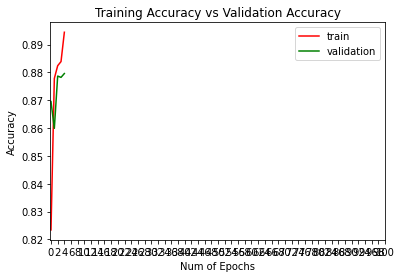

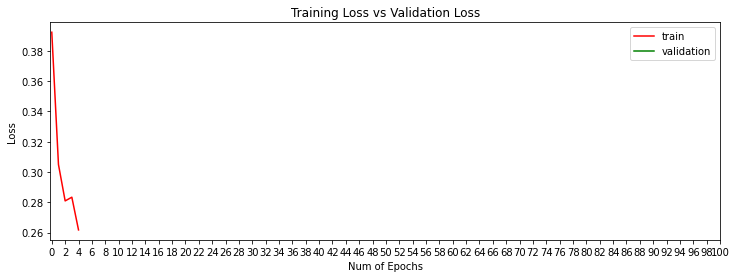

In [40]:
plt.figure(221)

plt.figure(0)
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'g')
plt.xticks(np.arange(0, 101, 2.0))
plt.rcParams['figure.figsize'] = (12, 4)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
 
plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(0, 101, 2.0))
plt.rcParams['figure.figsize'] = (12, 4)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
 
plt.show()

### Compile and Train Model for Severe Toxicity 

In [41]:
# Fit model
epochs_2 = 200
batch_size_2 =32
#early_stopping_monitor_2 = EarlyStopping(patience=300)

In [42]:
#get number of columns in training data
n_cols_2 = X_train_g200_2.shape[1]
#n_cols = X_train_tfidf.shape[1]

DL_model_2 = keras.models.Sequential([
#     keras.layers.Dense(256, activation="relu",input_shape=(n_cols,)),
#     keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation="relu",input_shape=(n_cols_2,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
     keras.layers.Dense(10, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation="sigmoid")
    ])

In [43]:
DL_model_2.compile(loss=keras.losses.binary_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics=['accuracy'])
DL_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               98432     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                650       
_________________________________________________________________
dropout_6 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [44]:
my_callbacks_2 = [
    EarlyStopping(patience=5),
    ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    TensorBoard(log_dir='logs'),
]

In [ ]:
#train model
history_2 = DL_model_2.fit(X_train_g200_2, y_train_g200_2, 
                    epochs=epochs_2, batch_size=batch_size_2, shuffle=True,
                    validation_split=0.2, callbacks=my_callbacks_2)

Epoch 1/200
23/23 [==============================] - 1s 13ms/step - loss: 0.6587 - accuracy: 0.5940 - val_loss: 0.5033 - val_accuracy: 0.9290
Epoch 2/200
23/23 [==============================] - 0s 7ms/step - loss: 0.5696 - accuracy: 0.7106 - val_loss: 0.3981 - val_accuracy: 0.8962
Epoch 3/200
23/23 [==============================] - 0s 7ms/step - loss: 0.4499 - accuracy: 0.7874 - val_loss: 0.2376 - val_accuracy: 0.9235
Epoch 4/200
23/23 [==============================] - 0s 7ms/step - loss: 0.3681 - accuracy: 0.8326 - val_loss: 0.1912 - val_accuracy: 0.9344
Epoch 5/200
23/23 [==============================] - 0s 7ms/step - loss: 0.3207 - accuracy: 0.8587 - val_loss: 0.1684 - val_accuracy: 0.9399
Epoch 6/200
23/23 [==============================] - 0s 7ms/step - loss: 0.2953 - accuracy: 0.8752 - val_loss: 0.1765 - val_accuracy: 0.9290
Epoch 7/200
23/23 [==============================] - 0s 7ms/step - loss: 0.2989 - accuracy: 0.8820 - val_loss: 0.1476 - val_accuracy: 0.9399
Epoch 8/200


In [ ]:
#testing
scores_2 = DL_model_2.evaluate(X_test_g200_2, y_test_g200_2, batch_size=32, verbose=1)
print('Test result: %.3f loss: %.3f' % (scores_2[1]*100,scores_2[0]))

In [ ]:
#save model to disk
model_json = DL_model_2.to_json()
with open('model_ann_severe_toxic.json', 'w') as json_file:
    json_file.write(model_json)
DL_model_2.save_weights('model_ann_severe_toxic.h5') 

In [ ]:
plt.figure(221)

plt.figure(0)
plt.plot(history_2.history['accuracy'],'r')
plt.plot(history_2.history['val_accuracy'],'g')
plt.xticks(np.arange(0, 101, 2.0))
plt.rcParams['figure.figsize'] = (12, 4)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
 
plt.figure(1)
plt.plot(history_2.history['loss'],'r')
plt.plot(history_2.history['val_loss'],'g')
plt.xticks(np.arange(0, 101, 2.0))
plt.rcParams['figure.figsize'] = (12, 4)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
 
plt.show()

# Submission Data Set

In [ ]:
df_test = pd.read_csv('comments_to_score.csv',low_memory = False) 

In [ ]:
import time
t_start = time.time()

df_test['clean']=df_test['text'].apply(lambda x: text_process_1(x))


t_stop = time.time()
print('Time elapsed: {:.3f} seconds'.format(t_stop - t_start))

In [ ]:
import time
t_start = time.time()

df_test['sent_vec_1']=df_test['clean'].apply(lambda x: sent_vectorizer_1(x))

t_stop = time.time()
print('Time elapsed: {:.3f} seconds'.format(t_stop - t_start))

In [ ]:
X_test=df_test['sent_vec_1']
X_test

In [ ]:
import time
t_start = time.time()

df_test_fin=pd.DataFrame()


for idx, row in enumerate(X_test):
    #print((roww))
    #print(list(roww))
    row_df=pd.Series(X_test[idx]).to_frame()
    row_df_2=row_df.T
    df_test_fin=pd.concat([df_test_fin, row_df_2])
    #row_df= pd.DataFrame(roww)
#     row_df_2=row_df.T
#     ddd=pd.concat([ddd, row_df_2])

df_test_fin = df_test_fin.fillna(0)

t_stop = time.time()
print('Time elapsed: {:.3f} seconds'.format(t_stop - t_start))

In [ ]:
test_ids=df_test['comment_id']
test_ids

#### Predict Severe Toxicity

In [ ]:
Y_test_pred_Sev_tox=DL_model_2.predict(df_test_fin)
Y_test_pred_Sev_tox_2=pd.DataFrame(Y_test_pred_Sev_tox)
Y_test_pred_Sev_tox_2

#### Predict Regular Toxicity

In [ ]:
Y_test_pred_reg_tox=DL_model.predict(df_test_fin)
Y_test_pred_reg_tox_2=pd.DataFrame(Y_test_pred_reg_tox)
Y_test_pred_reg_tox_2

In [ ]:
df_merge=pd.concat([test_ids, Y_test_pred_reg_tox_2, Y_test_pred_Sev_tox_2], axis=1)
df_merge.columns=["comment_id","b","d"]

df_merge['score']=df_merge['b']+df_merge['d']
df_merge.pop('b')
df_merge.pop('d')
df_merge

In [ ]:
df_merge.to_csv('submission.csv', index=False)